<a href="https://colab.research.google.com/github/rifqoi/BERT-Sentiment-Analysis/blob/main/cleanbabynotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
!wget https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
!wget https://raw.githubusercontent.com/datascienceid/stopwords-bahasa-indonesia/master/stopwords_id_satya.txt -O stopword.txt

--2022-07-05 06:46:08--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/kamus_alay.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49923 (49K) [text/plain]
Saving to: ‘kamus_alay.csv’

kamus_alay.csv      100%[===================>]  48.75K  --.-KB/s    in 0.007s  

2022-07-05 06:46:09 (7.24 MB/s) - ‘kamus_alay.csv’ saved [49923/49923]

--2022-07-05 06:46:09--  https://raw.githubusercontent.com/ezaaputra/Sentiment-Analysis-Using-BERT/main/flip_cat_balance.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 

In [2]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 7.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=15c22010539c0863a921302be255d6ddfb64091d977a7aa04834a713bbbea4f5
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 9.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.1 MB/s 
     |████████████████████████████████| 101 kB 10.4 MB/s 
     |████████████████████████████████| 596 kB 8.3 MB/s 
     |████████████████████████████████| 6.6 MB 22.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
  

In [87]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

import tensorflow as tf

from transformers import TFBertForSequenceClassification, BertConfig, BertTokenizer
from transformers import InputExample, InputFeatures

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df_path = '2kdata.json'
stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_alay.csv'

In [18]:
# Import data
df = pd.read_json("2kdata.json")

In [20]:
df = df.sample(frac=1)

In [21]:
df = df[["tweets", "sentiment"]]
df

,tweets,sentiment
572,"Yg bisa dipangkas,lakukan!klo yg udh keburu ja...",Negative
1188,Mantap nih dgn adanya formula e jakarta semaki...,Positive
1343,"Sirkuit balap Formula E di kawasan Ancol, Jaka...",Neutral
1936,"Ya aku harap juga begini, semoga tidak mundur ...",Positive
1289,Percuma anggota DPRD PDI-P DKI Jakarta hanya m...,Negative
...,...,...
510,100% tidak akan pernah ada gelaran formula e d...,Negative
1599,Ketua Fraksi di DPRD DKI Jakarta Achmad Yani. ...,Neutral
1799,Listeners kamu udah tau belom informasi tentan...,Neutral
2020,panitia penyelenggara Formula E Jakarta (Jakar...,Neutral


In [22]:
df.tweets = df.tweets.apply(lambda x: x.lower())
df

,tweets,sentiment
572,"yg bisa dipangkas,lakukan!klo yg udh keburu ja...",Negative
1188,mantap nih dgn adanya formula e jakarta semaki...,Positive
1343,"sirkuit balap formula e di kawasan ancol, jaka...",Neutral
1936,"ya aku harap juga begini, semoga tidak mundur ...",Positive
1289,percuma anggota dprd pdi-p dki jakarta hanya m...,Negative
...,...,...
510,100% tidak akan pernah ada gelaran formula e d...,Negative
1599,ketua fraksi di dprd dki jakarta achmad yani. ...,Neutral
1799,listeners kamu udah tau belom informasi tentan...,Neutral
2020,panitia penyelenggara formula e jakarta (jakar...,Neutral


In [18]:
count = 0
for x in df.itertuples():
  if count == 10:
    break
  print(x.tweets)
  count += 1

4 tahun di jakarta cuma dpt stadion jis (cuma numpang nyelsein) dan formula e yg belum jelas blas...... makan tu gubernur seagama.... cukup jakarta aja yg dibohongin
harusnya tulisannya enjoy jakarta karena formula e sukses nama indonesia pasti terbawa juga, selama ini proses pengerjaan hingga pembangunan melalui jalan yg terjal dan curam cobaan demi cobaan dilalui hingga saat ini, tapi disayangkan kesannya projek ini hanya projek pemda dki.
nah loh belum ada progres apa"udah ada biaya tambahan ke kontraktor untuk bikin sirkkuit formula e ini adalah azab dari allah swt tidak merestui evert formula e untuk pemprov dki jakarta yang suka bohongin rakyatnya,dan juga mengatasnamakan pemulihan ekonomi rakyat dki jakarta.
s7 , tapi kasih tau dong, pembalap yg terkenal d formula e... soalnya kemarin jakarta antusias menyambut pembalap gp kayak marquez, daviouoso dll... gimana mau d tonton kalo pembalapnya ga ada yg kenal....😃😃😃😃
satu aja harapan dan doa saya, semoga tidak ada sabotase dari pih

In [38]:
def clean_data(x):
    # Mengubah emoji menjadi kata 
    x = emoji.demojize(x)
    # Menghapus @username
    x = re.sub(r"@[A-Za-z0-9]\w+", "", x)  # Remove @
    # Menghapus link website
    x = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", x)  # Remove http links
    # Menghapus new line
    x = re.sub(r"\n", " ", x)
    # Menghapus whitespace pada sekitar kalimat
    x = x.strip()
    # Menghapus hashtag
    x = re.sub(r"\B(#\w+)+", r" ", x)
    # Mengubah % menjadi persen
    x = re.sub(r"(\d+) ?%", "\\1 persen", x)
    # Menghapus simbol-simbol
    x = re.sub(r"[^\w]", " ", x)
    # Menghapus huruf berulang 
    x = re.sub(r'(.)\1+', r'\1\1', x)     
    # Menghapus spasi berulang
    x = re.sub('\s+', ' ', x)
    return x


In [39]:
string_example = "1%#FORMULAE #MANTAPJIWA @HeriYan20910746 @nobody26813 @michellejakbar tong kosonggggg!!😂 semua ada kontraknya, formula e itu kontrak 5 tahun, dan akan ada selama 5 tahun kedepan, dan bukan tidak mungkin akan ada ajang atau event lainnya, namanya juga jakarta, pusat indonesia, kemungkinan2 eo event2 lain untuk pakai pasti ada🙏👍👍👍 https://t.co/WP8jKb3wuW"

In [40]:
print(clean_data(string_example))

1 persen tong kosongg face_with_tears_of_joy semua ada kontraknya formula e itu kontrak 5 tahun dan akan ada selama 5 tahun kedepan dan bukan tidak mungkin akan ada ajang atau event lainnya namanya juga jakarta pusat indonesia kemungkinan2 eo event2 lain untuk pakai pasti ada folded_hands thumbs_up thumbs_up thumbs_up 


In [49]:
df_clean = df.copy()
df_clean['tweets'] = df.tweets.apply(clean_data)
df_clean.head()

,tweets,sentiment
572,yg bisa dipangkas lakukan klo yg udh keburu ja...,Negative
1188,mantap nih dgn adanya formula e jakarta semaki...,Positive
1343,sirkuit balap formula e di kawasan ancol jakar...,Neutral
1936,ya aku harap juga begini semoga tidak mundur j...,Positive
1289,percuma anggota dprd pdi p dki jakarta hanya m...,Negative


In [115]:
df_tokenized = df.copy()
df_tokenized["tweets"] = df_clean.tweets.apply(word_tokenize)
df_tokenized

,tweets,sentiment
572,"[yg, bisa, dipangkas, lakukan, klo, yg, udh, k...",Negative
1188,"[mantap, nih, dgn, adanya, formula, e, jakarta...",Positive
1343,"[sirkuit, balap, formula, e, di, kawasan, anco...",Neutral
1936,"[ya, aku, harap, juga, begini, semoga, tidak, ...",Positive
1289,"[percuma, anggota, dprd, pdi, p, dki, jakarta,...",Negative
...,...,...
510,"[100, persen, tidak, akan, pernah, ada, gelara...",Negative
1599,"[ketua, fraksi, di, dprd, dki, jakarta, achmad...",Neutral
1799,"[listeners, kamu, udah, tau, belom, informasi,...",Neutral
2020,"[panitia, penyelenggara, formula, e, jakarta, ...",Neutral


In [128]:
kamus_alay = pd.read_csv('kamus_alay.csv')

alay_word_dict = {}

for ele in kamus_alay.itertuples():
  alay_word_dict[ele.slang] = ele.formal

# Custom kata alay wokwokw
custom_word = {
    "bong": "cebong",
    "bongg": "cebong",
    "cebi": "cebong",
    "cebii": "cebong",
    "drun": "kadrun",
    "drunn": "kadrun",
    "druunn": "kadrun",
    "gabener": "gubernur",
    "gabenerr": "gubernur",
    "goodbener": "gubernur",
    "goodbenerr": "gubernur",
    "gotbener": "gubernur",
    "gub": "gubernur",
    "gutbener": "gubernur",
    "gutbenerr": "gubernur",
    "even": "event",
    "komitmen":  "commitment",
    "komitmenn":  "commitment",
    "komitmeen":  "commitment",
    "commitmentt": "commitment",
    "committmeentt": "commitment"
}

alay_word_dict.update(custom_word)

In [129]:
def normalize_text(x):
  # Ubah kata alay menjadi formal
  x = [alay_word_dict[word] if word in alay_word_dict else word for word in x]
  return x

df_normalized = df_tokenized.copy()
df_normalized["tweets"] = df_normalized.tweets.apply(normalize_text)

In [153]:
# Stopwords
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('indonesian'))

negation_words = ['tak', 'tidak', 'gak', 'enggak', 'nggak']
strong_words = ["sekali", 'sangat', 'terlalu', 'amat', 'benar']
stopwords_to_remove = [negation_words, strong_words]

for words_list in stopwords_to_remove:
  for word in words_list:
    stopwords_list.discard(word)

def remove_stopwords(x):
  x = [word for word in x if word not in stopwords_list]
  return x

df_stripped_stopwords = df_normalized.copy()
df_stripped_stopwords["tweets"] = df_stripped_stopwords.tweets.apply(remove_stopwords)
df_stripped_stopwords

,tweets,sentiment
572,"[dipangkas, lakukan, keburu, jalan, masuk, kan...",Negative
1188,"[mantap, nih, formula, e, jakarta, mendunia]",Positive
1343,"[sirkuit, balap, formula, e, kawasan, ancol, j...",Neutral
1936,"[ya, harap, semoga, tidak, mundur, jadwalnya, ...",Positive
1289,"[anggota, dprd, pdi, p, dki, jakarta, menyorot...",Negative
...,...,...
510,"[100, persen, tidak, gelaran, formula, e, jaka...",Negative
1599,"[ketua, fraksi, dprd, dki, jakarta, achmad, ya...",Neutral
1799,"[listeners, tau, informasi, balap, mobil, form...",Neutral
2020,"[panitia, penyelenggara, formula, e, jakarta, ...",Neutral


In [147]:
print(df.tweets[572])
print(df_clean.tweets[572])
print(df_tokenized.tweets[572])
print(' '.join(df_normalized.tweets[572]))
print(df_stripped_stopwords.tweets[572])

yg bisa dipangkas,lakukan!klo yg udh keburu jalan dan masuk kantong,lanjut🤣🤣🤣kayak formula e gimana itu, komitmen fee 500 milliar😆😆😆enjoy lah warga jakarta, gubernur nya oon
yg bisa dipangkas lakukan klo yg udh keburu jalan dan masuk kantong lanjut rolling_on_the_floor_laughing rolling_on_the_floor_laughing rolling_on_the_floor_laughing kayak formula e gimana itu komitmen fee 500 milliar grinning_squinting_face grinning_squinting_face grinning_squinting_face enjoy lah warga jakarta gubernur nya oon
['yg', 'bisa', 'dipangkas', 'lakukan', 'klo', 'yg', 'udh', 'keburu', 'jalan', 'dan', 'masuk', 'kantong', 'lanjut', 'rolling_on_the_floor_laughing', 'rolling_on_the_floor_laughing', 'rolling_on_the_floor_laughing', 'kayak', 'formula', 'e', 'gimana', 'itu', 'komitmen', 'fee', '500', 'milliar', 'grinning_squinting_face', 'grinning_squinting_face', 'grinning_squinting_face', 'enjoy', 'lah', 'warga', 'jakarta', 'gubernur', 'nya', 'oon']
yang bisa dipangkas lakukan kalau yang sudah keburu jalan da

In [149]:
print(df.tweets[570])
print(df_normalized.tweets[570])
print(' '.join(remove_stopwords(df_tokenized.tweets[570])))

tak peduli warga nyemplung dan mati di sungai tak peduli minyak goreng langka di jakarta tak peduli jakarta kebanjiran tak peduli kasus covid melonjak di jkt  maaf...sy sibuk ngurusin formula e yg akan melambungkan nama saya utk pilpres.  ttd teroris ayat dan mayat
['tak', 'peduli', 'warga', 'nyemplung', 'dan', 'mati', 'di', 'sungai', 'tak', 'peduli', 'minyak', 'goreng', 'langka', 'di', 'jakarta', 'tak', 'peduli', 'jakarta', 'kebanjiran', 'tak', 'peduli', 'kasus', 'covid', 'melonjak', 'di', 'jakarta', 'maaf', 'saya', 'sibuk', 'mengurusi', 'formula', 'e', 'yang', 'akan', 'melambungkan', 'nama', 'saya', 'untuk', 'pilpres', 'ttd', 'teroris', 'ayat', 'dan', 'mayat']
tak peduli warga nyemplung mati sungai tak peduli minyak goreng langka jakarta tak peduli jakarta kebanjiran tak peduli covid melonjak jkt maaf sy sibuk ngurusin formula e yg melambungkan nama utk pilpres ttd teroris ayat mayat


In [155]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stemmer.stem("mengembalikan")
def stemming_text(x):
  x = [stemmer.stem(word) for word in x]
  return x

df_stemmed = df_stripped_stopwords.copy()
df_stemmed["tweets"] = df_stemmed.tweets.apply(stemming_text)
df_stemmed

,tweets,sentiment
572,"[pangkas, laku, keburu, jalan, masuk, kantong,...",Negative
1188,"[mantap, nih, formula, e, jakarta, dunia]",Positive
1343,"[sirkuit, balap, formula, e, kawasan, ancol, j...",Neutral
1936,"[ya, harap, moga, tidak, mundur, jadwal, mari,...",Positive
1289,"[anggota, dprd, pdi, p, dki, jakarta, sorot, p...",Negative
...,...,...
510,"[100, persen, tidak, gelar, formula, e, jakarta]",Negative
1599,"[ketua, fraksi, dprd, dki, jakarta, achmad, ya...",Neutral
1799,"[listeners, tau, informasi, balap, mobil, form...",Neutral
2020,"[panitia, selenggara, formula, e, jakarta, jak...",Neutral


In [162]:
df_stemmed.tweets[2020]

['panitia',
 'selenggara',
 'formula',
 'e',
 'jakarta',
 'jakarta',
 'e',
 'prix',
 'minimal',
 '50',
 'ribu',
 'tiket',
 'jual',
 'harga',
 'rendah',
 'capai',
 'rp350',
 'ribu',
 'juta']

In [158]:
print(df.tweets[2020])
print(stemmer.stem(df.tweets[2020]))

panitia penyelenggara formula e jakarta (jakarta e-prix) menyebutkan minimal sebanyak 50 ribu tiket siap dijual dengan harga paling rendah mencapai rp350 ribu hingga jutaan
panitia selenggara formula e jakarta jakarta e-prix sebut minimal banyak 50 ribu tiket siap jual dengan harga paling rendah capai rp350 ribu hingga juta


In [ ]:
def make_corpus(column):
    
    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)     
        
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one
        
    return corpus

In [ ]:
# Takes a while
corpus = make_corpus(df_v2.review_text)

In [ ]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 9086


In [154]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [ ]:
corpus_freq = word_freq(corpus, top=20)

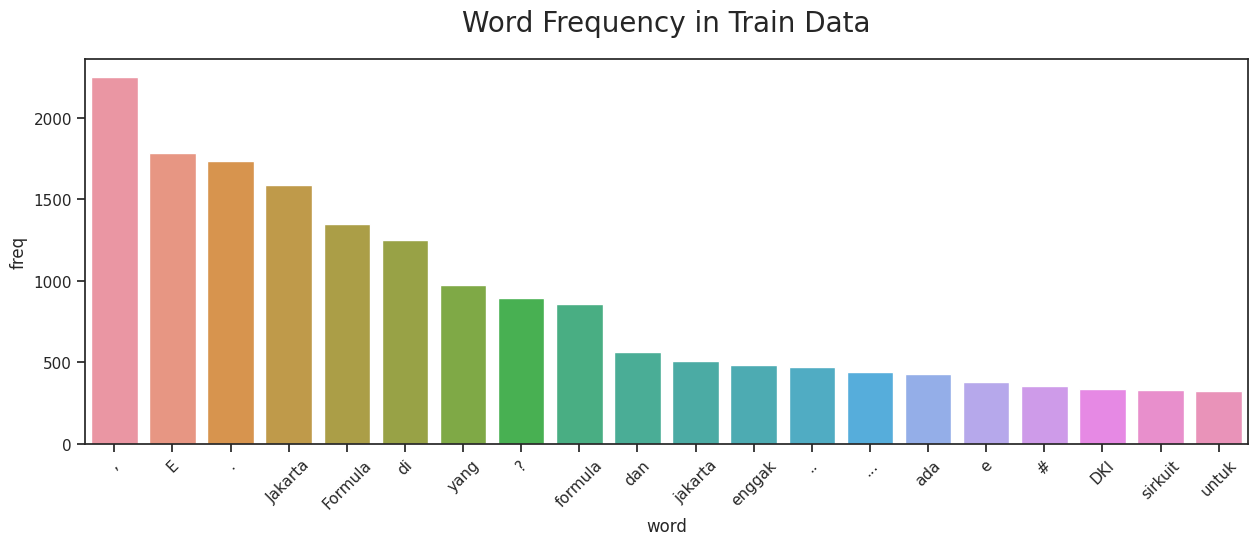

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

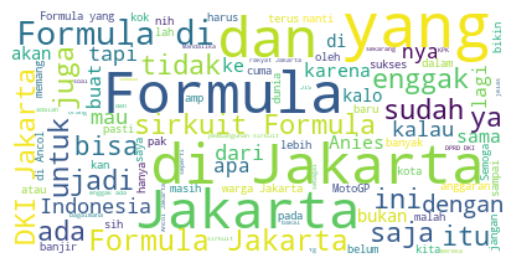

In [ ]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# train val split
train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.sentiment, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.sentiment, random_state=1)

In [ ]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.labels = 3

model = TFBertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config, )

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  124441344 
                                                                 
 dropout_227 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 124,445,189
Trainable params: 124,445,189
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def convert_data_to_examples(train, val, DATA_COLUMN, LABEL_COLUMN, test=None): 
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
  
  if test is not None:
    test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                            text_a = x[DATA_COLUMN], 
                                                            text_b = None,
                                                            label = x[LABEL_COLUMN]), axis = 1)
    return train_InputExamples, validation_InputExamples, test_InputExamples

  return train_InputExamples, validation_InputExamples


In [ ]:
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [ ]:
LABEL2INDEX = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
INDEX2LABEL = {0: 'Positive', 1: 'Neutral', 2: 'Negative'}

In [ ]:
train_set.sentiment = train_set.sentiment.map(lambda x: LABEL2INDEX[x])
val_set.sentiment = val_set.sentiment.map(lambda x: LABEL2INDEX[x])
test_set.sentiment = test_set.sentiment.map(lambda x: LABEL2INDEX[x])

In [ ]:
DATA_COLUMN = 'tweets'
LABEL_COLUMN = 'sentiment'

# train and test is your dataset
train_InputExamples, validation_InputExamples, test_InputExamples = convert_data_to_examples(train_set, val_set,  DATA_COLUMN, LABEL_COLUMN,test=test_set)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
print(train_InputExamples[0].text_a)
print(validation_InputExamples[1322])

FORMULA - E(wan)  Yang saya suka dari Formula-E, ternyata sirkuit-2 nya di dunia banyak yg mirip dgn bentuk hewan 😁  Bison 🐃 Nyamuk 🦗 Gajah 🐘 Bebek🦆 Kepiting 🦀 Onta 🐪  Khusus di Jakarta, kok mirip kuda lumping 🐴 Hewan palsu itu.... , sepalsu janji gubernurnya. .....
InputExample(guid=None, text_a='Jakarta ada Formula E, Bali ada BWF Finals, NTB ada WSBK dan MotoGP. Last but not least: Indonesia ada G20 🇮🇩', text_b=None, label=0)


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(train_data, epochs=7, validation_data=validation_data)

Epoch 1/7
90/90 [==============================] - 98s 868ms/step - loss: 0.7286 - accuracy: 0.6968 - val_loss: 0.7843 - val_accuracy: 0.6626
Epoch 2/7
90/90 [==============================] - 76s 843ms/step - loss: 0.2095 - accuracy: 0.9293 - val_loss: 0.9652 - val_accuracy: 0.7340
Epoch 3/7
90/90 [==============================] - 76s 839ms/step - loss: 0.0489 - accuracy: 0.9883 - val_loss: 1.1121 - val_accuracy: 0.7365
Epoch 4/7
90/90 [==============================] - 76s 840ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 1.1570 - val_accuracy: 0.7414
Epoch 5/7
90/90 [==============================] - 76s 841ms/step - loss: 0.0174 - accuracy: 0.9951 - val_loss: 1.1806 - val_accuracy: 0.7734
Epoch 6/7
90/90 [==============================] - 76s 841ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 1.2788 - val_accuracy: 0.7512
Epoch 7/7
90/90 [==============================] - 76s 839ms/step - loss: 0.0119 - accuracy: 0.9975 - val_loss: 1.3573 - val_accuracy: 0.7660


In [ ]:
model.predict(test_data)

array([[ 0.71904737, -2.3895214 ,  5.833724  , -2.1502326 , -2.5164723 ],
       [-2.1406744 ,  6.278587  , -1.2686003 , -1.8893396 , -1.6630346 ],
       [-1.8614568 , -2.3424306 ,  7.163891  , -1.6810726 , -1.7062114 ],
       ...,
       [-1.8441917 ,  6.338615  , -1.9321404 , -1.857481  , -1.6031955 ],
       [-1.9193181 , -2.5814524 ,  7.1384673 , -1.3747284 , -1.4817519 ],
       [-2.2110054 , -0.83661515,  6.841761  , -2.1998377 , -2.1194448 ]],
      dtype=float32)

In [ ]:
evaluate = model.evaluate(test_data)
print('Loss of the model is - ', evaluate[0])
print('Accuracy of the model is - ', evaluate[1]*100, '%')

classes =  ["Positive", "Neutral", "Negative"]
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
# print('Confusion Matrix')
# conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
# df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
# ax = sns.heatmap(df_cm, annot=True, cmap='Blues')

# ax.set_title('Seaborn Confusion Matrix with labels\n\n')
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ')

7/7 [==============================] - 2s 298ms/step - loss: 1.5066 - accuracy: 0.7463
Loss of the model is -  1.5066324472427368
Accuracy of the model is -  74.6268630027771 %


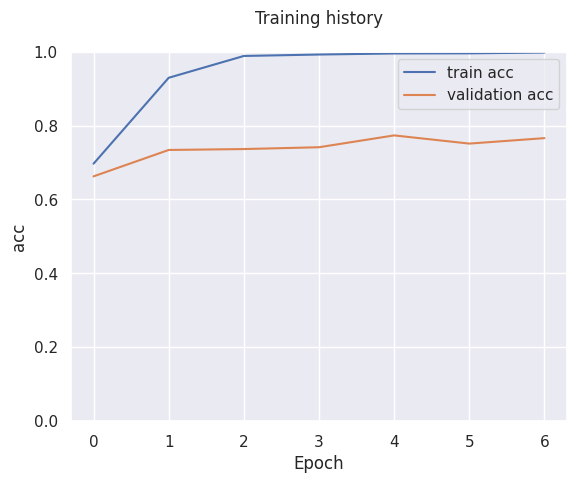

In [ ]:
sns.set()
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Overfit parah owkwokw

In [ ]:
test_sentences = list(test_set["tweets"])
tf_batch = tokenizer(test_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels =  ["Positive", "Neutral", "Negative"]
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(test_sentences)):
  print(test_sentences[i], ": ", labels[label[i]])

Yth pak  , gelaran Moto3, moto2 &amp; MotoGP telah sukses digelar... Coba bapak berpikir jernih, untuk event Formula E yang akan digelar di Jakarta dipindah ke Mandalika pak. Karena sampai saat ini gak jelas juntrungannya, sampai kapan sirkuit formula E nya jadi...🙏 :  Negative
dipikir formula e itu badan usaha milik dki jakarta apa ya :  Neutral
Formula E buat taun depan, di jakarta, pasti lbh mahal lg tuh 🤭.  Tapi ya, kalo ga jadi lg mah atuh malu gubernur  nya wkwkwk :  Negative
Padahal pemerintah juga mendorong Formula E, FE atau MotoGP sama-sama nguntungin buat Indonesia itu sendiri padahal, jadi kontroversi karena diadain di Jakarta aja dan Gubernurnya pak Anies. :  Negative
Selesai saja belum....selesaikan dan laksanakan saja Formula E itu....daripada ditangkap KPK. Uang orang Jakarta sdh nggak jelas kemana.... :  Negative
Saya mengharapkan event formula E jakarta juga sukses sbgmn event motogp mandalika. Pasti semua ada plus minusnya dalam penyelenggaraan, apalagi semua event p

In [ ]:
list(test_set["tweets"])

['Yth pak  , gelaran Moto3, moto2 &amp; MotoGP telah sukses digelar... Coba bapak berpikir jernih, untuk event Formula E yang akan digelar di Jakarta dipindah ke Mandalika pak. Karena sampai saat ini gak jelas juntrungannya, sampai kapan sirkuit formula E nya jadi...🙏',
 'dipikir formula e itu badan usaha milik dki jakarta apa ya',
 'Formula E buat taun depan, di jakarta, pasti lbh mahal lg tuh 🤭.  Tapi ya, kalo ga jadi lg mah atuh malu gubernur  nya wkwkwk',
 'Padahal pemerintah juga mendorong Formula E, FE atau MotoGP sama-sama nguntungin buat Indonesia itu sendiri padahal, jadi kontroversi karena diadain di Jakarta aja dan Gubernurnya pak Anies.',
 'Selesai saja belum....selesaikan dan laksanakan saja Formula E itu....daripada ditangkap KPK. Uang orang Jakarta sdh nggak jelas kemana....',
 'Saya mengharapkan event formula E jakarta juga sukses sbgmn event motogp mandalika. Pasti semua ada plus minusnya dalam penyelenggaraan, apalagi semua event perdana. Mudah2 kedepan semakin sukses